<a href="https://colab.research.google.com/github/edgarshmavonyan/adam_optim_project/blob/experiments/RefactoredExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/edgarshmavonyan/adam_optim_project
!cd adam_optim_project && git checkout experiments
#!cd adam_optim_project && git pull origin experiments

Cloning into 'adam_optim_project'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 49 (delta 18), reused 42 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.
Branch 'experiments' set up to track remote branch 'experiments' from 'origin'.
Switched to a new branch 'experiments'


In [0]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
from adam_optim_project.adam import AdamOptimizer
from adam_optim_project.mnist import MnistTest
from tqdm import tqdm_notebook
%matplotlib inline

#### Линейная регрессия

In [0]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
    
    def forward(self, x):
        res = self.linear(x)
        return res

In [0]:
class LinearRegressionTest:
    def __init__(self, input_dim, data_len):
        self.input_dim = input_dim
        self.data_len = data_len
        self.mse = torch.nn.MSELoss()
        self.X = torch.rand(data_len, input_dim)
        self.y = torch.rand(data_len, 1)
        X_np = np.array(self.X)
        best_w = np.linalg.inv(X_np.T@X_np)@X_np.T@np.array(self.y)
        self.min_err = X_np @ best_w - np.array(self.y)
    
    def __call__(self, optimizer_, optimizer_params, epochs=1000, **kwargs):
        model = LinearRegression(self.input_dim)
        optimizer = optimizer_(model.parameters(), **optimizer_params)
        loss_values = []

        for i in range(epochs):
            inputs = Variable(self.X)
            labels = Variable(self.y)
            def eval():
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = self.mse(outputs, labels)
                loss.backward()
                return loss
            loss = eval()
            optimizer.step(eval)
            loss_values.append(loss.item())

        return np.log(np.array(loss_values) - np.mean(self.min_err**2) + 1e-5)

#### Настройки оптимайзеров:

In [0]:
lr = 0.013
optimizers = [
    torch.optim.SGD,
    torch.optim.SGD,
    AdamOptimizer,
    AdamOptimizer,
    torch.optim.LBFGS,
]
optimizer_names = [
    "SGD", "Nesterov Momentum SGD", "Adam", "AMSGrad", "LBFGS"
]
optimizer_params = [
    dict(lr=lr),
    dict(lr=lr, momentum=0.9, nesterov=True),
    dict(lr=lr/5),
    dict(lr=lr/5, amsgrad=True),
    dict(lr=0.01, history_size=20),
]
batch_sizes = [64, 64, 64, 64, None]

In [0]:
def evaluate_test(test, test_args=dict(), optimizers=optimizers, optimizer_params=optimizer_params, optimizer_names=optimizer_names, batch_sizes=batch_sizes, test_name=""):
    if test_name:
        print(f"Test {test_name}")
    loss_list = []

    for optimizer, params, name, batch_size in zip(optimizers, optimizer_params, optimizer_names, batch_sizes):
        print(f"{name} optimizer:")
        try:
            loss_list.append(test(optimizer, params, batch_size=batch_size, **test_args))
        except BaseException as e:
            print(e)
            loss_list.append([])

    return loss_list

def plot_results(loss_list, optimizer_names=optimizer_names, ylim=None):
    plt.figure(figsize=(15, 10))
    for loss, name in zip(loss_list, optimizer_names):
        plt.plot(loss, label=name)
    
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    if ylim:
        plt.ylim((0, ylim))
    plt.legend()

#### Нейронки + MNIST/CIFAR-10

In [80]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


transform_mnist = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)

trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_mnist)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, 5)
        self.bn1 = nn.BatchNorm2d(30)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class FastNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(32 * 32 * 3, 1000)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(1000)
    self.fc2 = nn.Linear(1000, 500)
    self.bn2 = nn.BatchNorm1d(500)
    self.fc3 = nn.Linear(500, 10)
    
  def __call__(self, x):
    x = self.flat(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.bn1(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.bn2(x)
    return self.fc3(x)

class FastNetMnist(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(28 * 28, 400)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(400)
    self.fc2 = nn.Linear(400, 500)
    self.bn2 = nn.BatchNorm1d(500)
    self.fc3 = nn.Linear(500, 10)
    
  def __call__(self, x):
    x = self.flat(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.bn1(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.bn2(x)
    return self.fc3(x)


criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def NN_test(optimizer_class, optimizer_params, network=MnistNet, trainset=trainset_mnist, epoch_num=20, batch_size=64):
    torch.cuda.empty_cache()
    if batch_size is None:
        batch_size = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
    net = network()
    net.to(device)
    optimizer = optimizer_class(net.parameters(), **optimizer_params) #, lr=0.001, momentum=0.9)
    cur_loss = []
    for epoch in tqdm_notebook(range(epoch_num), leave=False):  # loop over the dataset multiple times

        running_loss = 0.0
        cnt = 0
        for data in tqdm_notebook(trainloader, leave=False):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            def closure():
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss
            
            loss = optimizer.step(closure)

            running_loss += loss.item()
            cnt += 1
        cur_loss.append(running_loss / cnt)
    print('Finished Training')
    return cur_loss


Files already downloaded and verified
cuda:0


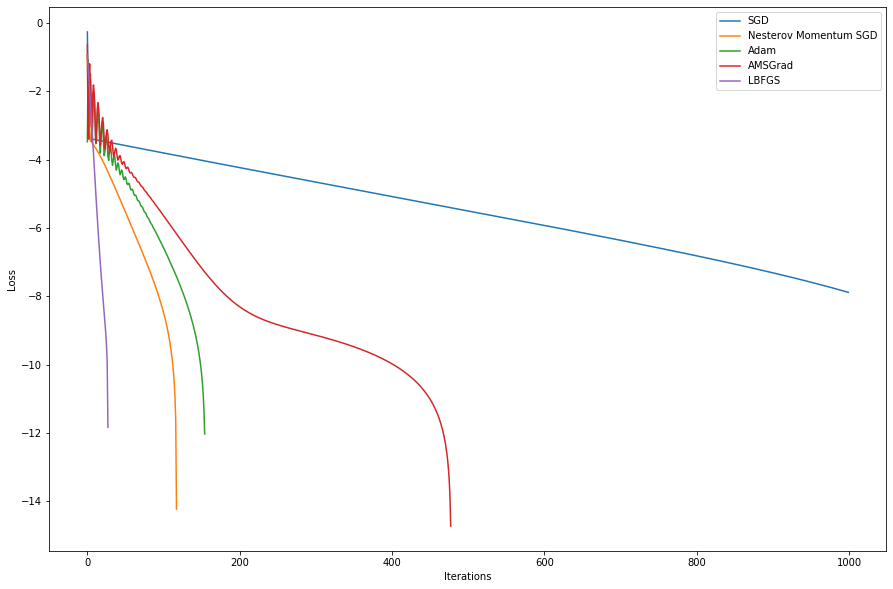

In [0]:
input_dim = 100
data_len = 2000
test = LinearRegressionTest(input_dim, data_len)
#lin_reg_res = evaluate_test(test)
plot_results(lin_reg_res)

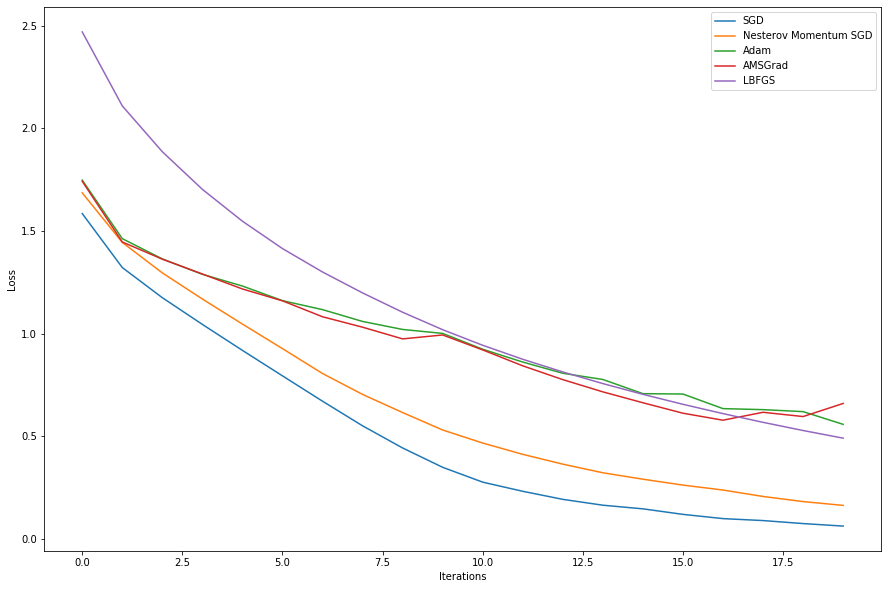

In [0]:
#cifar_results_fastnet = evaluate_test(NN_test, dict(network=FastNet, trainset=trainset_cifar))
plot_results(cifar_results_fastnet)

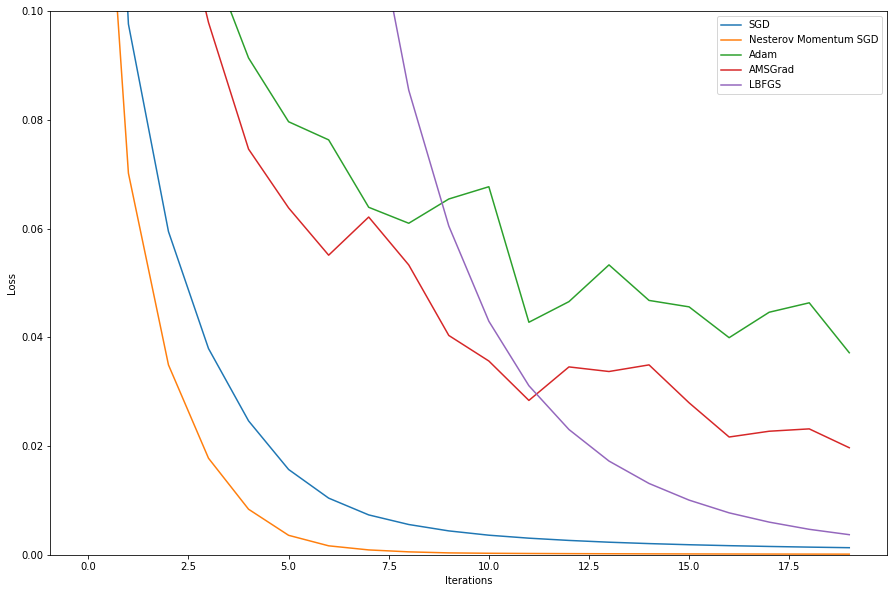

In [83]:
#mnist_results_fastnet = evaluate_test(NN_test, dict(network=FastNetMnist, trainset=trainset_mnist))
plot_results(mnist_results_fastnet, ylim=0.1)

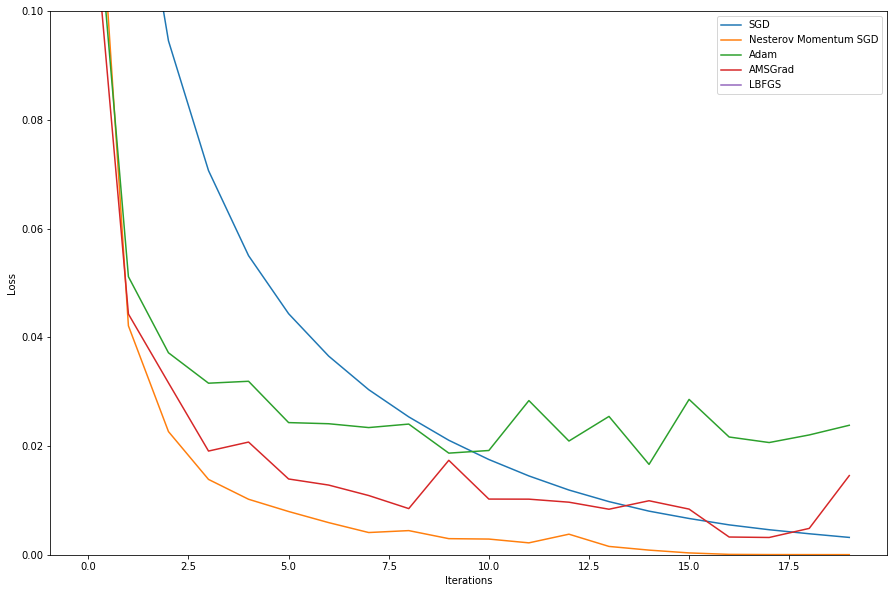

In [86]:
#mnist_results_net = evaluate_test(NN_test, dict(network=MnistNet, trainset=trainset_mnist))
plot_results(mnist_results_net, ylim=0.1)

[0.0001     0.00016379 0.00026827 0.0004394  0.00071969 0.00117877
 0.0019307  0.00316228 0.00517947 0.00848343 0.01389495 0.02275846
 0.03727594 0.06105402 0.1       ]


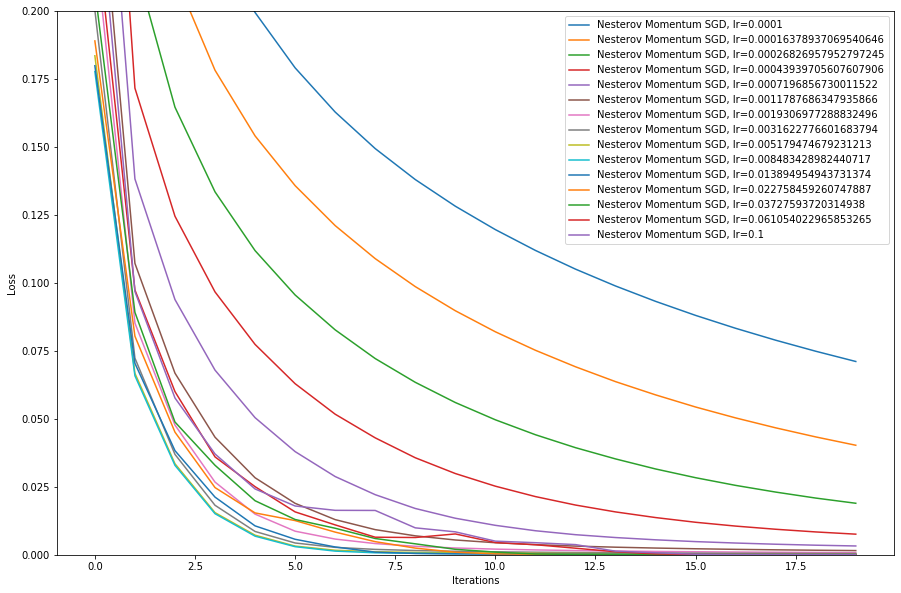

In [92]:
best_idx = 1
lr_list = np.geomspace(0.0001, 0.1, num=15)
print(lr_list)
lr_opt = [optimizers[best_idx]]*len(lr_list)
lr_params = []
lr_names = [f"{optimizer_names[best_idx]}, lr={lr}" for lr in lr_list]
lr_batch_sizes = [64]*len(lr_list)
for lr in lr_list:
    params = optimizer_params[best_idx].copy()
    params['lr'] = lr
    lr_params.append(params)

#lr_results = evaluate_test(NN_test, dict(network=FastNetMnist, trainset=trainset_mnist), optimizers=lr_opt, optimizer_params=lr_params, optimizer_names=lr_names, batch_sizes=lr_batch_sizes)
plot_results(lr_results, lr_names, ylim=0.2)

In [0]:
best_lr = 0.08